# Longitudinal model
---
In this exercise, we will develop the Longitudinal model and forward simulate the behavior of the airplane after deviating the elevator for a short time. 

In [38]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import jdc
from PreviousLessonObjects import AeroDynamics, TrimCondition
pylab.rcParams['figure.figsize'] = 10, 10

# Lesson 3

### Longitudinal Model 

We need to define the state vector as:

$$
X=[x,y,z,u,v,w,\phi,\theta,\psi,p,q,r]
$$


But the constraints are:
$$
\begin{align}
\phi & = 0  \\
\psi & = 0 \\
v & = 0 \\
p & = 0 \\
r & = 0
\end{align}
$$

Thus the state vector will be reduced to: 
$$
X= \begin{bmatrix} \theta \\ u \\ w \\ q \end{bmatrix} 
$$
Which the last four terms in the Linearize Longitudinal model. 

In this section, we will develop a simple object called `Airplane` which will contain state vector for longitudinal direction and the `advance_state` function which will be advancing the state by `dt`.

In [39]:
class Airplane:
    
    def __init__(self):
        
        '''
        Initialize the object using the velocity and the trim angle of attack.
        Args:
            v: airplane velocity
            alpha_at_trim: aan angle of attack at the trim condition
        '''
        
        self.x=np.zeros(4)
        
        
    def advance_state(self, dt, x_dot):
        '''
        Advance state vector values by dt time 
        Args:
            dt: elapsed time interval since the last update 
            x_dot: the vector containing derivatives of the state vector
        '''
        
        self.x += dt * x_dot

# LongitudinalModel
We will use the equations 36, 37, 46 from model.pdf to perform time advance simulation an airplane. 

In [40]:
class LongitudinalModel(AeroDynamics):
    
    def __init__(self):
        super(LongitudinalModel, self).__init__()

    def f_x_f_z(self, thrust, v, alpha, delta_e, theta):
        '''
        Calculates forces in x and z directions 
        Args:
            thrust: thrust value at the trim condition
            v: airplane velocity
            alpha: aan angle of attack at the trim condition
            delta_e: The elevator deflection angle at level flight
            theta: The pitch angle 
            
        Returns:
            Force in x direction, force in z direction 
        '''        
        lift = self.lift(v, alpha, delta_e)
        drag = self.drag(v, alpha)
        
        # TODO: Calculate the total force in X and Z directions. 
        
        f_x = lift * np.sin(alpha) - drag * np.cos(alpha) + thrust - self.mass * self.g * np.sin(theta)
        f_z = -lift * np.cos(alpha) - drag * np.sin(alpha) + self.mass * self.g * np.cos(theta)

        return f_x, f_z 

    def m(self, v, alpha, delta_e):
        '''
        Calculates moment along the Y axis. 
        Args:
            v: airplane velocity
            alpha: aan angle of attack at the trim condition
            delta_e: The elevator deflection angle at level flight
            
        Returns:
            Pitching moment
        '''  
        pitching_momment = self.pitch_moment(v, alpha, delta_e)
        
        return pitching_momment
    
    

## Simulating forward in time 

Now that we have all the elements governing the longitudinal directions characterized we can simulate the airplane behavior in time.

First we need to define the trim conditions and increase the velocity by 5 [m/s] to see how airplane will responde. 

In [41]:
Trim = TrimCondition()
v_at_trim = Trim.v_min_t()
v_at_trim += 5
thrust_at_trim = Trim.thrust(v_at_trim)
alpha_at_trim = Trim.alpha_for_trim(v_at_trim)
delta_e_at_trim = Trim.delta_e(alpha_at_trim)


Second the will declare the airplane object with its state vector and will simulate it in time. 
Please note the for level fligth $\theta = \alpha$

In [46]:
total_time = 100
dt = 0.01 

Drone = Airplane()
MotionModel = LongitudinalModel()

theta = alpha_at_trim
Drone.x = np.array([theta, v_at_trim*np.cos(alpha_at_trim), -v_at_trim*np.sin(alpha_at_trim), 0])

state_history= Drone.x
delta_e = delta_e_at_trim
thrust = thrust_at_trim 

for _ in range(int(total_time/dt)):
    
    theta = Drone.x[0]
    u = Drone.x[1]
    w = Drone.x[2]
    q = Drone.x[3]
    
    # TODO: calculate the next parameters 
    # alpha = function of w and u 
    # v = function of w and u 
    alpha = np.arctan(w/u)
    v = np.sqrt(u**2 + w**2)
    
    f_x, f_z = MotionModel.f_x_f_z(thrust, v, alpha, delta_e, theta)
    m = MotionModel.m(v, alpha, delta_e)
    
    # TODO: colculate the derivatived of the state vector equations 28 - 31 in model.pdf. 
    #  x_dot=np.array([_,_,_,_])
    x_dot = np.array([q, 
                     f_x/MotionModel.mass - q * w,
                     f_z/MotionModel.mass + q * u,
                     m/MotionModel.j_y])
    
    Drone.advance_state(dt, x_dot)
    state_history = np.vstack((state_history,Drone.x))
  

Plotting the angular velocity $q$

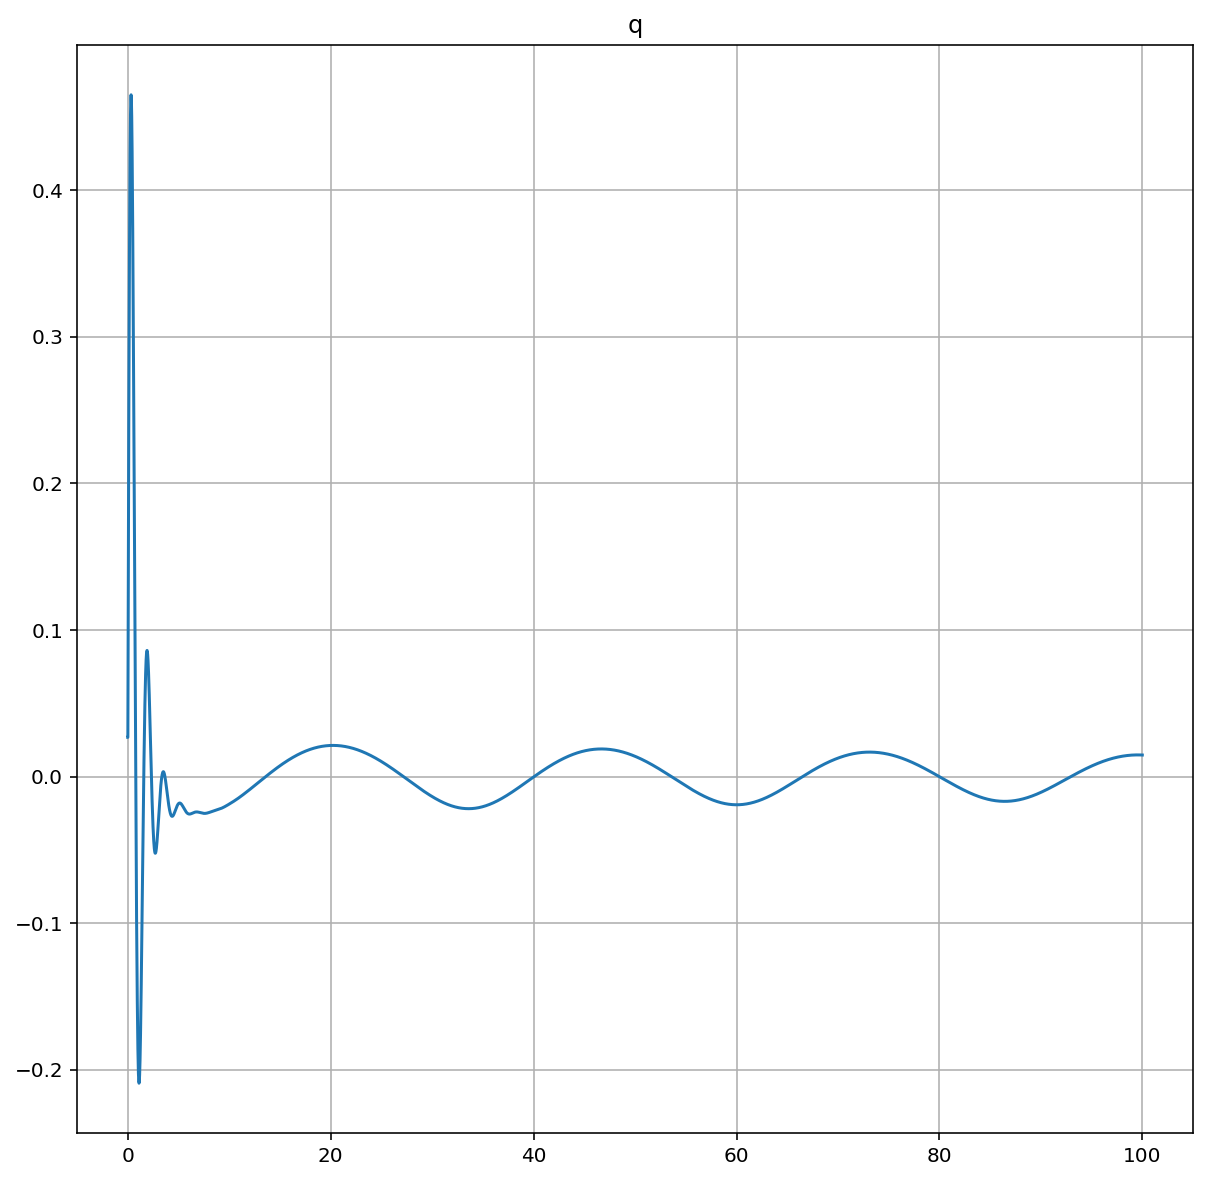

In [47]:
plt.plot(np.arange(0,total_time,dt),state_history[:-1,-1])
plt.title('q')
    
plt.grid()
plt.show()